In [1]:
import requests
import json
import datetime as dt
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import ruptures as rpt
from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
colors = sns.color_palette('deep', 8)
sns.set_palette(colors)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:923: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
Using TensorFlow backend.


#### Ethereum Time Series Analysis
1. Introduction
    - Imports:
        - Python: datetime, time, warnings
        - Preprocessing/Viz: numpy, pandas, matplotlib, seaborn, sklearn.preprocessing, ruptures
        - Modeling: statsmodels.tsa.arima_model, tensorflow, keras.models, .layers, .backend
        - Evaluation: statsmodels.tsa.stattools, scipy.stats, sklearn.metrics
    - Description of Research Question/Task
2. Data: TS Only
    - Scrape/APIs/Clean
    - Load/EDA
        - Visualize TS: ADF (Augmented Dickey-Fuller) Unit Root Test
        - Distribution: D'Agostino/Pearson Normality Test
    - Changepoint Analysis
        - PELT (Pruned Exact Linear Time)
    - Feature Engineering: changepoint dummies
3. Modeling/Forecasting
    - ARIMA
        - Stationarity: ADF
        - AR/MA (Auto Regressive/Moving Average): ACF/PACF (Auto/Partial Auto Correlation Functions)
        - Modeling: AIC/BIC (Akaike/Bayesian Information Critera), RMSE (Root Mean Squared Error)
        - Forecasting: Moving window, RMSE
    - Neural Networks
        - MLP ANN (Multi Layer Perceptron Artificial Neural Network): simple, deep, RMSE
        - LSTM RNN (Long Short-Term Memory Recurrent Neural Network): RMSE
    - Visualize/Summarize Results
5. Data: Exogenous Variables
    - Scrape/APIs/Clean
    - Granger Causality
    - Feature Engineering: Collinearity, PCA (Principle Component Analysis), UMAP(?) (Uniform Manifold Approximation and Projection)
6. Modeling/Forecasting
    - ARIMA(X)
    - Neural Networks
        - MLP ANN
        - LSTM RNN
    - Visualize/Summarize Results
7. Overall Summary & Conclusions
8. Deployment

# 1. Introduction

# 2. Data

## 2.1 Data Access & Preprocessing
- Functions to make API calls
- Get desired eth & exogenous variable data (for use in second part of analysis)
- Clean/combine into single df to draw from throughout analysis

In [ ]:
def cryptocompare_data(symbol,
                       comparison_symbol='USD',
                       all_data=True,
                       rows=1,
                       aggregate=1,
                       write_to=False):
    
    # symbol = symbol of desired coin
    # comparison symbol = symbol for currency to price with
    # to subset data, set all_data to false, then specificy with rows parameter
    # write_to = write dataframe to supported filetype: csv, json, pkl
    
    # api call
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(),
                    comparison_symbol.upper(),
                    rows,
                    aggregate)
    
    if all_data:
        url += '&allData=true'
    
    # store in dataframe
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['date'] = [dt.datetime.fromtimestamp(d) for d in df.time]
    df['date'] = df.date.dt.date
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    df.drop('time', axis=1, inplace=True)
    df = df[['date', 'open', 'high', 'low', 'close', 'volumefrom', 'volumeto']]
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # write to file option
    return_df=True
    if write_to is not False:
        return_df=False
        date = dt.datetime.today().strftime('%Y-%m-%d')
        filename = symbol.lower() + '_data_' + date + '.{}'.format(write_to)
        write_df(df, write_to, filename)
        
    if return_df is True:
        return df
    
def fred_data(series_id,
              api_key,
              file_type='json',
              frequency='d',
              raw=False,
              write_to=False):
    
    # series_id = string, symbol from fred
    # filetype options: xml, json, txt, xls
    # frequency options: d = daily, w = weekly, bw = biweekly
    # m = monthly, q = quarterly, sa = semiannual, a = annual
    # raw=True will skip the preprocessing and return the raw data
    # write_to=write dataframe to supported filetype: csv, json, pkl
    
    url = 'https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type={}&frequency={}'\
                  .format(series_id,
                          api_key,
                          file_type,
                          frequency)
    
    response = requests.get(url)
    data = response.json()['observations']
    df = pd.DataFrame(data)
    
    if raw is False:
        df.drop(['realtime_end', 'realtime_start'], axis=1, inplace=True)
        df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
        df.rename(columns={'value':series_id.lower()}, inplace=True)
        
    return_df=True
    if write_to is not False:
        return_df=False
        date = dt.datetime.today().strftime('%Y-%m-%d')
        filename = series_id.lower() + '_data_' + date + '.{}'.format(write_to)
        write_df(df, write_to, filename)
        
    if return_df is True:
        return df

def write_df(df, write_to, filename):
    if write_to == 'csv':
        df.to_csv('{}'.format(filename), index=False)
    elif write_to == 'pkl':
        df.to_pickle('{}'.format(filename))
    elif write_to == 'json':
        df.to_json('{}'.format(filename), orient='split')
    else:
        print('function does not support writing to {}'.format(write_to))
        print('format filetype as shown (string in all lower case)')
        print('supported filetypes: csv, json, pkl')
        
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [ ]:
# get coin data
coins = ['ETH', 'BTC', 'XRP', 'EOS', 'LTC', 'XLM', 'XMR']

# create empty df for each coin
coins_d = {coin.lower(): pd.DataFrame() for coin in coins}

# populate coin dfs with respective coin data
for key, df in coins_d.items():
    coins_d[key] = cryptocompare_data(symbol=key)

# add coin names to columns & preview dfs
for key, df in coins_d.items():
    cols_orig = list(coins_d[key].columns)[1:]
    cols_new = ['date']
    for col in cols_orig:
        cols_new.append('{}_{}'.format(key, col))
    coins_d[key].columns = cols_new
    coins_d[key].set_index('date', inplace=True, drop=True)
    #display(coins_d[key].head(1))
    
# combine to single df
coins_df = pd.concat([df for key, df in coins_d.items()], axis=1)
display(coins_df.head(1))

# convert keys:values to variables = assignments
#locals().update(coins_d)

In [ ]:
# get fred data
fred_apikey = get_file_contents('fred_apikey')

indices = {
    'VIXCLS':'d', # cboe volatility index
    'TWEXB':'w', # trade weighted usd index
    'EFFR':'d' # effective federal funds rate
    }

# create empty df for each index
indices_d = {index: pd.DataFrame() for index in indices}

# populate dfs with index data
for key in set(indices.keys()) and set(indices_d.keys()):
    indices_d[key] = fred_data(series_id=key,
                               api_key=fred_apikey,
                               frequency = indices[key])
    indices_d[key].set_index('date', inplace=True, drop=True)

# lowercase dict keys, preview dfs
indices_d =  {key.lower(): value for key, value in indices_d.items()}

#for key, df in indices_d.items():
#    display(df.head(1))

# combine to single df    
fred_df = pd.concat([df for key, df in indices_d.items()], axis=1)
display(fred_df.head(1))

# convert to variables = assignments
#locals().update(indices_d)

In [ ]:
# combine data into single df
df_alldata = pd.concat([coins_df, fred_df], axis=1)

# replace '.' with nan so ffill will catch everything
# '.' denotes a holiday
df_alldata.replace('.', np.nan, inplace=True)

# ffill values for weekends skipped by traditional indices
df_alldata.ffill(inplace=True)

# start dataframe at beginning of ethereum
df = df_alldata[df_alldata.eth_close.isnull().sum():]
display(df.head(3))

# check missingness
for col in df.columns:
    if df['{}'.format(col)].isnull().any() == True:
        print(col)

In [ ]:
df.to_json('df.json', orient='split')

**Note**: EOS & XLM currencies started after ETH (hence their missing values). Will address this later when dealing with exogenous variables

## 2.2 Time Series EDA

In [2]:
raw = pd.read_json('df.json', orient='split')
ts = pd.DataFrame(raw.eth_close).copy()
ts.head(3)

,eth_close
2015-08-06,3.0
2015-08-07,1.2
2015-08-08,1.2


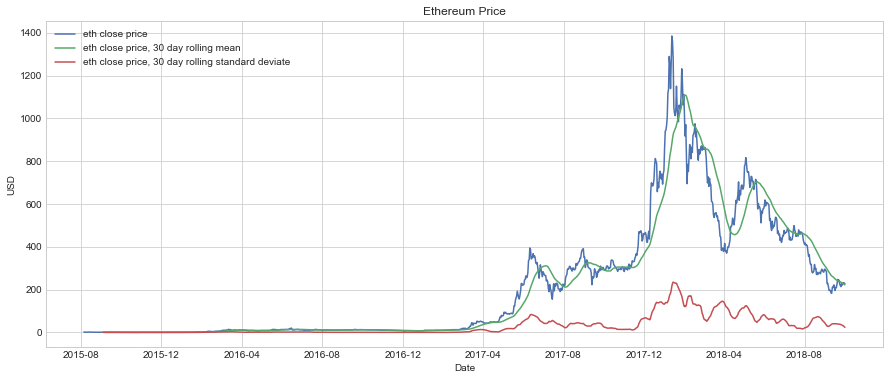

adf: -1.8220530088893083
pval: 0.3695692487064304
critical vals {'1%': -3.436155341313321, '5%': -2.8641034026875123, '10%': -2.568134825546958}


In [3]:
window = 30

plt.figure(figsize=(15,6))
plt.plot(
    ts.index.values,
    ts.eth_close,
    label='eth close price',
    color=colors[0]
)
plt.plot(
    ts.index.values,
    ts.eth_close.rolling(window).mean(),
    label='eth close price, {} day rolling mean'.format(window),
    color=colors[1]
)
plt.plot(
    ts.index.values,
    ts.eth_close.rolling(window).std(),
    label='eth close price, {} day rolling standard deviate'.format(window),
    color=colors[2]
)
plt.title('Ethereum Price')
plt.ylabel('USD')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(ts.eth_close)[0],
    adfuller(ts.eth_close)[1],
    adfuller(ts.eth_close)[4]))

**Interpretation:**
- Data displays trend(s), ADF test confirms non-stationarity
- Data does not appear to have a seasonality component
- Graph indicates presence of structural breaks

**To do:**
- Perform change point analysis
- Get stationary time series

### 2.2.1 Change point analysis

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


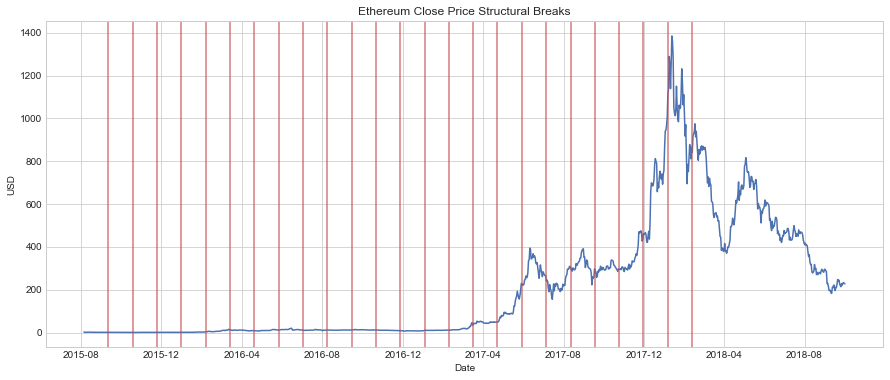

Change points by index: [37, 74, 111, 147, 184, 221, 258, 295, 332, 368, 405, 442, 479, 516, 553, 589, 626, 663, 700, 737, 774, 810, 847, 884, 921]


In [4]:
ts_prophet = ts.copy().reset_index()
ts_prophet.columns = (['ds', 'y'])

m = Prophet().fit(ts_prophet)

# populate df with changepoints
cpts_df = pd.DataFrame(
    {'index_locator':m.changepoints.index,
     'cpts':m.changepoints.values,
     'delta':m.params['delta'].mean(0)})

# plot prophet's findings
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Ethereum Close Price Structural Breaks')
ax.plot(
    ts.index.values,
    ts.eth_close,
    color=colors[0]
)
for pt in list(cpts_df.index_locator):
    plt.axvline(
        x=ts.index.values[pt],
        color=colors[2],
        alpha=.75
    )
ax.set_ylabel('USD')
ax.set_xlabel('Date')
plt.show()

print('Change points by index: {}'.format(list(cpts_df.index_locator)))

#fig, ax = plt.subplots(figsize=(15,3))
#for pt in list(cpts_df.index_locator):
#    plt.axvline(
#        x=pt,
#        color=colors[2],
#        alpha=.75
#    )
#ax.set_ylabel('magnitude')
#ax.set_xlabel('potential changepoint')

#plt.show()

#print('Change points by index: {}'.format(list(cpts_df.index_locator)))

In [5]:
# extract significant potential changepoints
points = []
for i, row in cpts_df.iterrows():
    if cpts_df.delta[i] >= 0.5:
        points.append(row.index_locator)
    elif cpts_df.delta[i] <= -0.5:
        points.append(row.index_locator)

# create dummies for breaks
for i, point in enumerate(points):
    ts['break_{}'.format(i+1)] = 0
    
    if point != points[-1]:
        ts['break_{}'.format(i+1)][point:points[i+1]] = 1
   
    elif point == points[-1]:
        ts['break_{}'.format(i+1)][point:] = 1

### 2.2.2 Stationarity

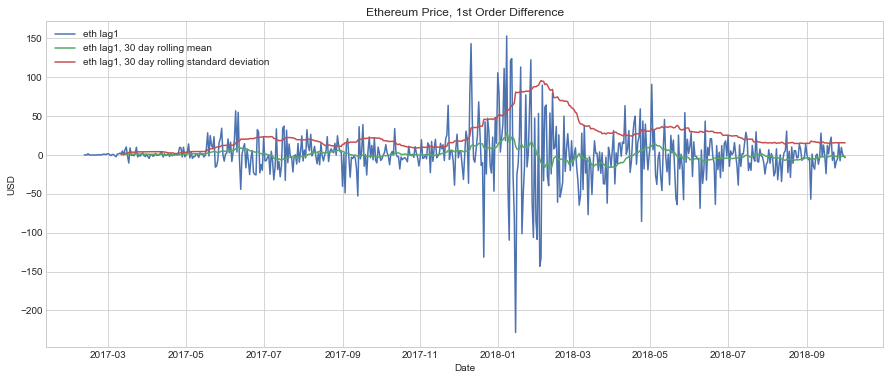

1st order differenced ADF test results

price:
adf -3.7057
pval 0.004033108119210174
critical vals {'1%': -3.441694608475642, '5%': -2.866544718556839, '10%': -2.5694353738653684}

rolling mean:
adf -4.4036
pval 0.0002925383869002565
critical vals {'1%': -3.442295604706236, '5%': -2.866809328264463, '10%': -2.569576376859504}

std dev:
adf -3.0364
pval 0.03163336210507303
critical vals {'1%': -3.442295604706236, '5%': -2.866809328264463, '10%': -2.569576376859504}


In [6]:
# reset time series to exclude beginning
ts = ts[points[0]:]
# first order difference
ts['lag1'] = diff(ts.eth_close, k_diff=1)

window = 30
plt.figure(figsize=(15,6))
plt.plot(
    ts.index.values[1:],
    ts.lag1[1:],
    label='eth lag1',
    color=colors[0]
)
plt.plot(
    ts.index.values[1:],
    ts.lag1[1:].rolling(window).mean(),
    label='eth lag1, 30 day rolling mean',
    color=colors[1]
)
plt.plot(
    ts.index.values[1:],
    ts.lag1[1:].rolling(window).std(),
    label='eth lag1, 30 day rolling standard deviation',
    color=colors[2]
)
plt.title('Ethereum Price, 1st Order Difference')
plt.ylabel('USD')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

# ADF Tests
adf_lag1 = adfuller(ts.lag1.dropna())
adf_rollingmean = adfuller(ts.lag1.rolling(window).mean().dropna())
adf_rollingstd = adfuller(ts.lag1.rolling(window).std().dropna())

print('1st order differenced ADF test results')
print('\nprice:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_lag1[0], adf_lag1[1], adf_lag1[4]))
print('\nrolling mean:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_rollingmean[0], adf_rollingmean[1], adf_rollingmean[4]))
print('\nstd dev:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_rollingstd[0], adf_rollingstd[1], adf_rollingstd[4]))

# 3. Modeling & Forecasting Time Series

## 3.1 ARIMA
### 3.1.1 ACF/PACF

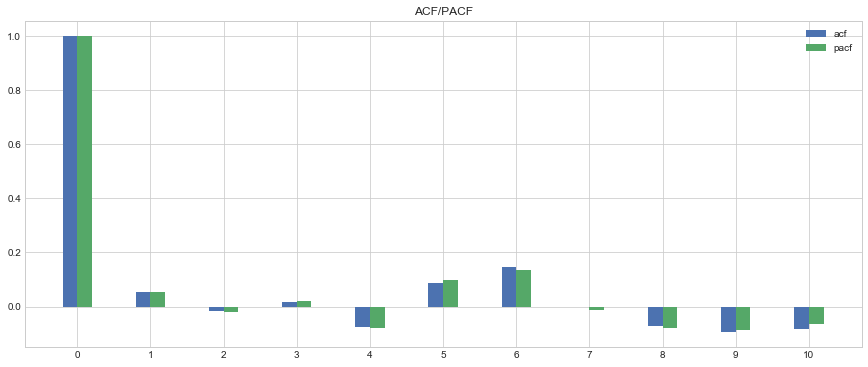

In [7]:
acf_lag1 = acf(ts.lag1.dropna(), nlags=10)
pacf_lag1 = pacf(ts.lag1.dropna(), nlags=10)

fig, ax = plt.subplots(figsize=(15,6))
ax.bar(
    [n-.1 for n in range(len(acf_lag1))],
    acf_lag1,
    label='acf',
    width=.2,
    color=colors[0],
    align='center'
)
ax.bar(
    [n+.1 for n in range(len(acf_lag1))],
    pacf_lag1,
    label='pacf',
    width=.2,
    color=colors[1],
    align='center'
)
ax.legend()
ax.set(title='ACF/PACF',
       xticks= [n for n in range(len(acf_lag1))])

plt.show()

**Interpretation**:
- ACF: perhaps a small MA component
- PACF perhaps a small AR component

### 3.1.2 ARIMA Modeling & Forecasting
- Build the following:
    - ARIMA(0,1,0): d=1, no AR/MA component
    - ARIMA(1,1,0): ar=1, d=1, no MA component
    - ARIMA(0,1,1): d=1, ma=1, no AR component
    - ARIMA(1,1,10: combine in single ARIMA model
- Evaluation:
    - AIC/BIC
    - RMSE

In [8]:
def arima_forecast(endog, order, window, n_steps=1, exog=None):
    start = 0
    stop = window
    aic = []
    preds = []
    
    for n in range(len(endog) - window):
        if exog is None:
            # sample data and train model
            model = ARIMA(
                endog=endog[start:stop],
                order=order
            ).fit()
            # make and store forecasts
            yhat = model.forecast(steps=n_steps)
        
        if exog is not None:
            # sample data and train model
            model = ARIMA(
                endog=endog[start:stop],
                exog=exog[start:stop],
                order=order
            ).fit(trend='nc')
            # make and store forecasts
            yhat = model.forecast(
                steps=n_steps,
                exog=exog[stop:stop+1]
            )
            
        # store results and step forward    
        aic.append(model.aic)
        preds.append(yhat[0][0])
        start += 1
        stop += 1
   
    results = np.array([preds, aic])
    return results

def rmse(observed, predicted):
    rmse = np.sqrt(mean_squared_error(observed[-len(predicted):], predicted))
    return rmse

In [9]:
endog = ts.eth_close
window = 30

d1_fc = arima_forecast(
    endog=endog,
    order=(0,1,0),
    window=window
)
ar1_fc = arima_forecast(
    endog=endog,
    order=(1,1,0),
    window=window
)
ma1_fc = arima_forecast(
    endog=endog,
    order=(0,1,1),
    window=window
)

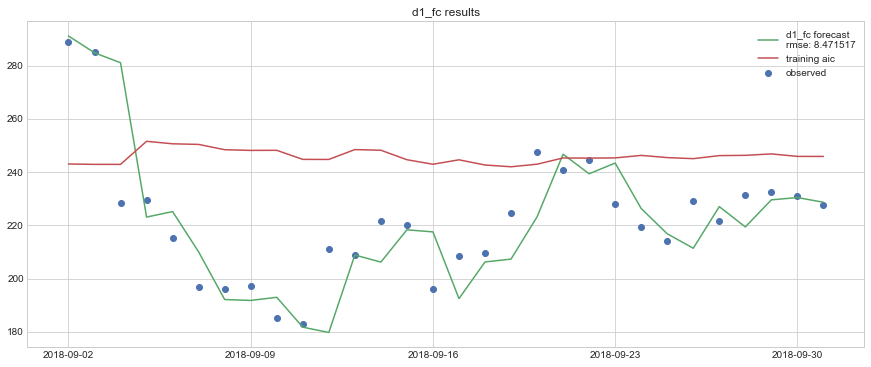

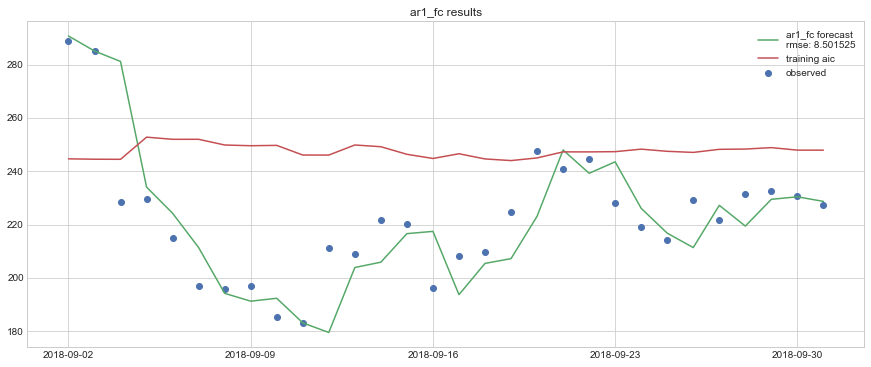

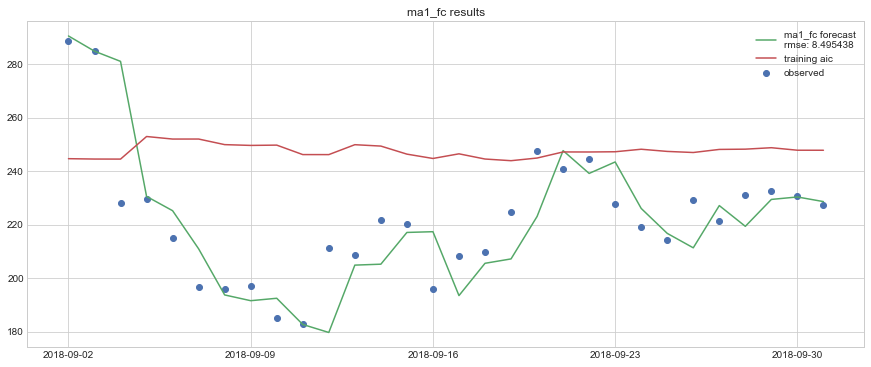

In [10]:
forecasts = {
    'd1_fc': d1_fc,
    'ar1_fc': ar1_fc,
    'ma1_fc': ma1_fc
}

for name, model in forecasts.items():
    plt.figure(figsize=(15,6))
    plt.plot(
        ts.eth_close[-len(model[0]):].index[-30:],
        model[0][-30:],
        label = '{} forecast\nrmse: {:.6f}'.format(
            name, rmse(ts.eth_close[-7:], model[0][-7:])),
        c=colors[1]
    )

    plt.scatter(
        ts.eth_close[-len(model[0]):][-30:].index,
        ts.eth_close[-len(model[0]):][-30:],
        label = "observed",
        c=colors[0]
    )
    
    plt.plot(ts.eth_close[-len(model[0]):].index[-30:],
            model[1][-30:],
            label='training aic',
            c=colors[2])
    plt.title('{} results'.format(name))
    plt.legend()
    plt.show()

In [11]:
exog = ts.loc[:, ~ts.columns.isin(['eth_close', 'lag1'])]

d1_fcx = arima_forecast(
    endog=endog,
    exog=exog,
    order=(0,1,0),
    window=window
)
ar1_fcx = arima_forecast(
    endog=endog,
    exog=exog,
    order=(1,1,0),
    window=window
)
ma1_fcx = arima_forecast(
    endog=endog,
    exog=exog,
    order=(0,1,1),
    window=window
)

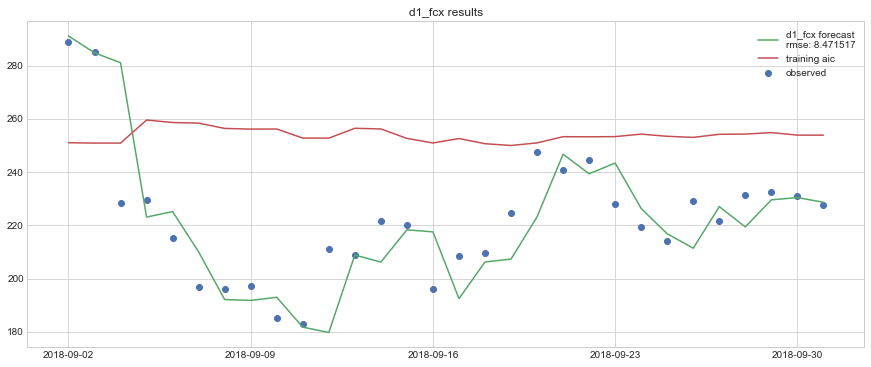

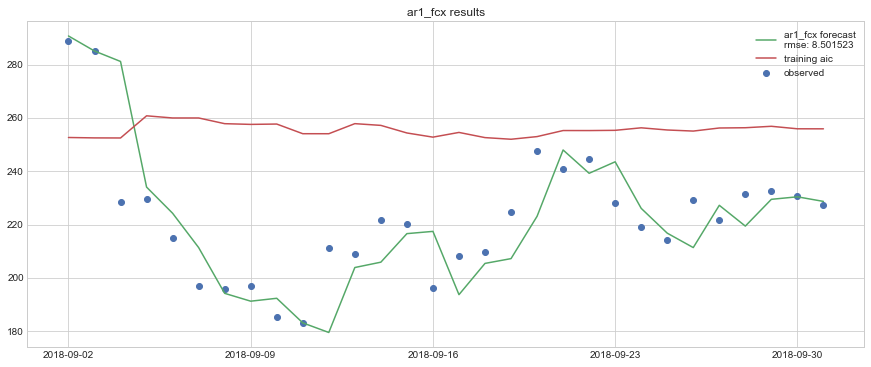

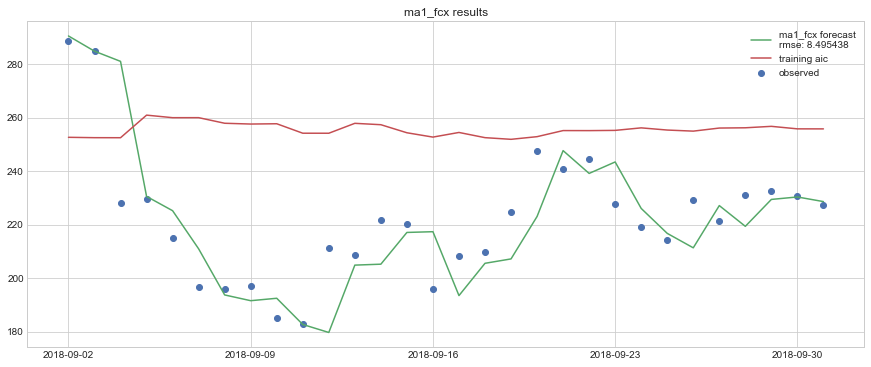

In [12]:
forecastsx = {
    'd1_fcx': d1_fcx,
    'ar1_fcx': ar1_fcx,
    'ma1_fcx': ma1_fcx
}

for name, model in forecastsx.items():
    plt.figure(figsize=(15,6))
    plt.plot(
        ts.eth_close[-len(model[0]):].index[-30:],
        model[0][-30:],
        label = '{} forecast\nrmse: {:.6f}'.format(
            name, rmse(ts.eth_close[-7:], model[0][-7:])),
        c=colors[1]
    )

    plt.scatter(
        ts.eth_close[-len(model[0]):].index[-30:],
        ts.eth_close[-len(model[0]):][-30:],
        label = "observed",
        c=colors[0]
    )
    
    plt.plot(ts.eth_close[-len(model[0]):].index[-30:],
            model[1][-30:],
            label='training aic',
            c=colors[2])
    plt.title('{} results'.format(name))
    plt.legend()
    plt.show()

## 3.2 Artifical Neural Networks

In [13]:
def shift_data(df, n_shifts):
    df_shifted = df.copy()
    for i in range(n_shifts):
        df = pd.concat([df, df_shifted.shift(i+1)], axis=1)
        df.dropna(axis=0, inplace=True)
    cols = list(df.columns)[1:]
    for i, col in enumerate(cols):
        cols[i] = 'shift_{}'.format(i+1)
    cols = [df.columns[0]] + cols
    df.columns = cols
    return df

In [14]:
# set series to manipulate for ANNs
ts_nn = pd.DataFrame(ts.eth_close.copy())
ts_nn.rename(columns={'eth_close':'unshifted'}, inplace=True)

# scale data
scaler = MinMaxScaler(feature_range=(0,1))
ts_scaled = scaler.fit_transform(ts_nn.values)
ts_nn = pd.DataFrame(ts_scaled).set_index(ts_nn.index.values)
ts_nn.columns = ['unshifted']
print("original df:\nshape: {}".format(ts_nn.shape))
display(ts_nn.head(3), ts_nn.tail(3))

ts_nn = shift_data(ts_nn, 30)
print("shifted df:\nshape: {}".format(ts_nn.shape))
display(ts_nn.head(3), ts_nn.tail(3))

original df:
shape: (600, 1)


,unshifted
2017-02-09,0.000000
2017-02-10,0.000066
2017-02-11,0.000058


,unshifted
2018-09-29,0.161071
2018-09-30,0.159826
2018-10-01,0.157344


shifted df:
shape: (570, 31)


,unshifted,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_21,shift_22,shift_23,shift_24,shift_25,shift_26,shift_27,shift_28,shift_29,shift_30
2017-03-11,0.008714,0.007360,0.005671,0.004637,0.003785,0.005511,0.006122,0.005736,0.005292,0.005926,...,0.001077,0.001085,0.001005,0.001172,0.001187,0.001208,0.000036,0.000058,0.000066,0.000000
2017-03-12,0.012456,0.008714,0.007360,0.005671,0.004637,0.003785,0.005511,0.006122,0.005736,0.005292,...,0.000859,0.001077,0.001085,0.001005,0.001172,0.001187,0.001208,0.000036,0.000058,0.000066
2017-03-13,0.012550,0.012456,0.008714,0.007360,0.005671,0.004637,0.003785,0.005511,0.006122,0.005736,...,0.001041,0.000859,0.001077,0.001085,0.001005,0.001172,0.001187,0.001208,0.000036,0.000058


,unshifted,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_21,shift_22,shift_23,shift_24,shift_25,shift_26,shift_27,shift_28,shift_29,shift_30
2018-09-29,0.161071,0.160139,0.153034,0.158516,0.147684,0.151316,0.157664,0.169770,0.167026,0.172056,...,0.134420,0.134988,0.148361,0.158829,0.157919,0.199384,0.202107,0.206511,0.206758,0.196785
2018-09-30,0.159826,0.161071,0.160139,0.153034,0.158516,0.147684,0.151316,0.157664,0.169770,0.167026,...,0.135257,0.134420,0.134988,0.148361,0.158829,0.157919,0.199384,0.202107,0.206511,0.206758
2018-10-01,0.157344,0.159826,0.161071,0.160139,0.153034,0.158516,0.147684,0.151316,0.157664,0.169770,...,0.126529,0.135257,0.134420,0.134988,0.148361,0.158829,0.157919,0.199384,0.202107,0.206511


In [15]:
# holdout last 7 days for test
train = ts_nn[:-7]
test = ts_nn[-7:]

X_train, X_test = train.iloc[:, 1:], test.iloc[:, 1:]
y_train, y_test = train.iloc[:, 0], test.iloc[:, 0]
print(X_train.shape, X_test.shape)

# reshape for lstm model
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape, X_test.shape)

(563, 30) (7, 30)
(563, 30, 1) (7, 30, 1)


In [16]:
def build_lstm(loss, optimizer, lr, X=X_train, metrics=['mse']):
    model = Sequential()
    model.add(LSTM(
        units=1,
        activation='tanh',
        use_bias=True,
        input_shape=(X.shape[1], X.shape[2])))

    model.compile(
        loss=loss,
        metrics=metrics,
        optimizer=optimizer
    )
    return model

def one_step_forecast(model, data):
    n_forecasts = len(data)
    preds = []
    for i in range(n_forecasts):
        X = data[i]
        X = X.reshape(1, X.shape[0], X.shape[1])
        yhat = model.predict(X)
        preds.append(yhat[0])
    return preds

In [17]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

# use sklearn wrapper to gridsearch params
lstm_tune = KerasRegressor(build_fn=build_lstm, verbose=0)

losses = ['mean_squared_error', 'mean_absolute_error', 'logcosh']
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learning_rates = [1.0, 0.01, 0.005, 0.002, 0.001]

params = dict(loss=losses, optimizer=optimizers, lr=learning_rates)
grid = GridSearchCV(estimator=lstm_tune, param_grid=params, n_jobs=-1)

start = time.time()
grid_results = grid.fit(X_train, y_train)
print("best params: {}".format(grid_results.best_params_))
print("GridsearchCV runtime: {:.1f} seconds".format(time.time() - start))

best params: {'loss': 'logcosh', 'lr': 0.005, 'optimizer': 'SGD'}
GridsearchCV runtime: 1100.8 seconds


In [30]:
lstm = build_lstm(
    loss='mean_squared_error',
    optimizer='Adamax',
    lr=0.005)
lstm.fit(X_train, y_train, epochs=500, verbose=1)

Epoch 1/500
563/563 [==============================] - 1s 3ms/step - loss: 0.0719 - mean_squared_error: 0.0719
Epoch 2/500
563/563 [==============================] - 1s 906us/step - loss: 0.0615 - mean_squared_error: 0.0615
Epoch 3/500
563/563 [==============================] - 0s 791us/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 4/500
563/563 [==============================] - 0s 784us/step - loss: 0.0441 - mean_squared_error: 0.0441
Epoch 5/500
563/563 [==============================] - 0s 854us/step - loss: 0.0373 - mean_squared_error: 0.0373
Epoch 6/500
563/563 [==============================] - 0s 782us/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 7/500
563/563 [==============================] - 0s 866us/step - loss: 0.0275 - mean_squared_error: 0.0275
Epoch 8/500
563/563 [==============================] - 0s 727us/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 9/500
563/563 [==============================] - 0s 683us/step - loss: 0.0220 - mean_squared

563/563 [==============================] - 0s 685us/step - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 74/500
563/563 [==============================] - 0s 718us/step - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 75/500
563/563 [==============================] - 1s 906us/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 76/500
563/563 [==============================] - 0s 693us/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 77/500
563/563 [==============================] - 0s 742us/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 78/500
563/563 [==============================] - 0s 698us/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 79/500
563/563 [==============================] - 0s 755us/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 80/500
563/563 [==============================] - 0s 658us/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 81/500
563/563 [==============================] - 0s 605us/step - loss: 0.0131 - mean_squared_e

Epoch 144/500
563/563 [==============================] - 0s 712us/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 145/500
563/563 [==============================] - 0s 861us/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 146/500
563/563 [==============================] - 0s 755us/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 147/500
563/563 [==============================] - 0s 703us/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 148/500
563/563 [==============================] - 0s 797us/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 149/500
563/563 [==============================] - 0s 789us/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 150/500
563/563 [==============================] - 0s 693us/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 151/500
563/563 [==============================] - 0s 681us/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 152/500
563/563 [==============================] - 1s 1ms/step - loss: 0.0

563/563 [==============================] - 0s 652us/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 216/500
563/563 [==============================] - 0s 748us/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 217/500
563/563 [==============================] - 0s 755us/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 218/500
563/563 [==============================] - 0s 712us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 219/500
563/563 [==============================] - 0s 711us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 220/500
563/563 [==============================] - 1s 965us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 221/500
563/563 [==============================] - 0s 859us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 222/500
563/563 [==============================] - 0s 741us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 223/500
563/563 [==============================] - 0s 699us/step - loss: 0.0100 - mean_s

563/563 [==============================] - 0s 875us/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 287/500
563/563 [==============================] - 0s 754us/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 288/500
563/563 [==============================] - 0s 733us/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 289/500
563/563 [==============================] - 0s 726us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 290/500
563/563 [==============================] - 0s 716us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 291/500
563/563 [==============================] - 0s 708us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 292/500
563/563 [==============================] - 0s 735us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 293/500
563/563 [==============================] - 0s 721us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 294/500
563/563 [==============================] - 0s 710us/step - loss: 0.0089 - mean_s

563/563 [==============================] - 0s 754us/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 358/500
563/563 [==============================] - 0s 730us/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 359/500
563/563 [==============================] - 0s 728us/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 360/500
563/563 [==============================] - 0s 737us/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 361/500
563/563 [==============================] - 0s 725us/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 362/500
563/563 [==============================] - 0s 746us/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 363/500
563/563 [==============================] - 0s 707us/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 364/500
563/563 [==============================] - 0s 715us/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 365/500
563/563 [==============================] - 0s 755us/step - loss: 0.0075 - mean_s

563/563 [==============================] - 0s 669us/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 429/500
563/563 [==============================] - 0s 696us/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 430/500
563/563 [==============================] - 0s 699us/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 431/500
563/563 [==============================] - 0s 883us/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 432/500
563/563 [==============================] - 0s 751us/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 433/500
563/563 [==============================] - 0s 637us/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 434/500
563/563 [==============================] - 0s 668us/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 435/500
563/563 [==============================] - 0s 812us/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 436/500
563/563 [==============================] - 0s 774us/step - loss: 0.0063 - mean_s

563/563 [==============================] - 0s 879us/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 500/500
563/563 [==============================] - 0s 702us/step - loss: 0.0052 - mean_squared_error: 0.0052


In [31]:
train_preds = one_step_forecast(lstm, X_train)
train_preds = scaler.inverse_transform(train_preds)
train_obs = scaler.inverse_transform(np.array(y_train).reshape(-1,1))
train_rmse = np.sqrt(mean_squared_error(train_obs, train_preds))
print("train rmse: {:.5f}".format(train_rmse))

test_preds = one_step_forecast(lstm, X_test)
test_preds = scaler.inverse_transform(test_preds)
test_obs = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
test_rmse = np.sqrt(mean_squared_error(test_obs, test_preds))
print("test rmse: {:.5f}".format(test_rmse))

train rmse: 98.03297
test rmse: 9.38286


# 4. Time Series with Exogenous Variables

# 5. Modeling & Forecasting with Exogenous Variables

# 6. Summary & Conclusions